# **Advanced Lane Finding** 
***
As a part of the Udacity Self Driving Car Engineer Nanodegree program, we use computer vision to implement to again implement lane finding, but using a more advanced set of techniques than the first project of the course.

---

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

1. [Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.](#camera_calibration)
2. [Apply a distortion correction to raw images.](#apply_distortion)
3. [Use color transforms, gradients, etc., to create a thresholded binary image.](#create_binary)
4. [Apply a perspective transform to rectify binary image ("birds-eye view").](#perspective)
5. [Detect lane pixels and fit to find the lane boundary.](#fit_lane)
6. [Determine the curvature of the lane and vehicle position with respect to center.](#curvature)
7. [Warp the detected lane boundaries back onto the original image.](#warp_lane)
8. [Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.](#final_output)

## Camera Calibration

<a id='camera_calibration'></a>

### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline


def getpoints(imgfiles, nx, ny, drawcorners=False, allowoffbyone=True):
    '''Construct image points and object points from chessboard calibration image files'''
    imgpoints = []
    objpoints = []
    imgsize = None

    # prepare constant object points to append if corners found in an image
    objp = np.zeros((nx*ny,3), dtype=np.float32)
    objp[:,:2] = np.mgrid[:nx,:ny].T.reshape(-1,2)

    # Process images and build imgpoints list
    for imgfile in imgfiles:
        
        img = mpimg.imread(imgfile)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        this_imgsize = gray.shape[::-1]
        if imgsize is None:
            imgsize = this_imgsize # store (width, height) for use by cv2.calibrateCamera()
        else:
            msg = 'Size mismatch: {}. {} != {}.'.format(imgfile, imgsize, gray.shape[::-1])
            # a couple of the images have an extra pixel in each dimension, but it should be
            # ok since the corners are within the smaller dimension range?
            # Thus, let's optionally allow it.
            allowedsizes = [this_imgsize]
            if allowoffbyone:
                allowedsizes.append((this_imgsize[0] - 1, this_imgsize[1] - 1))
            assert imgsize in allowedsizes, msg

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If corners found, draw corners, and append corresponding img/obj points
        if ret:
            
            # Optionally plot the images with corners drawn
            if drawcorners:
                cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                plt.figure()
                plt.imshow(img)
                plt.title(imgfile + ' corners')
            
            objpoints.append(objp)
            imgpoints.append(corners)
            
    
    return objpoints, imgpoints, imgsize

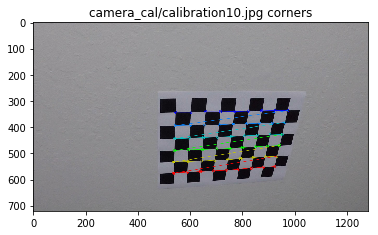

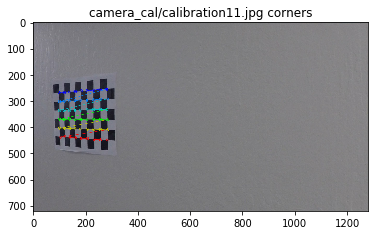

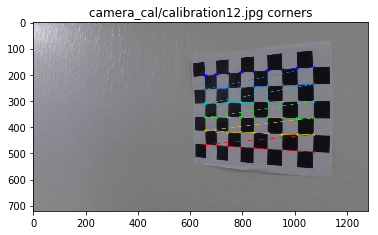

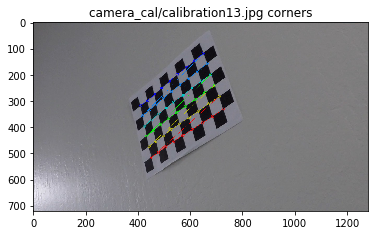

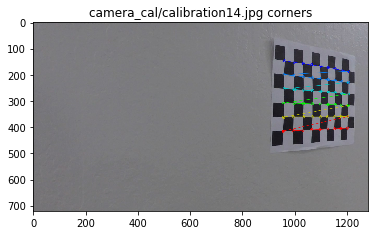

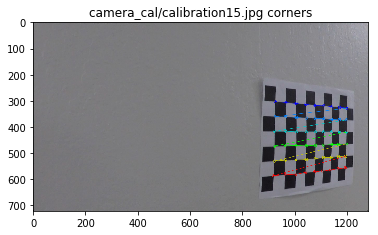

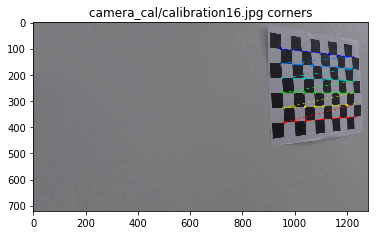

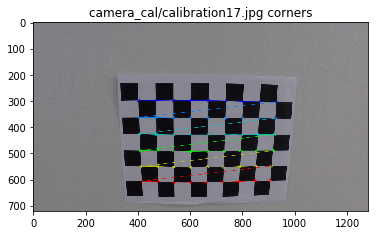

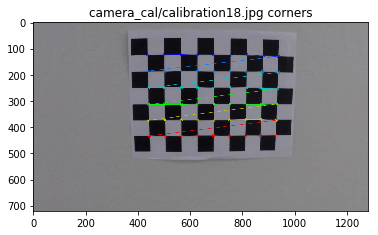

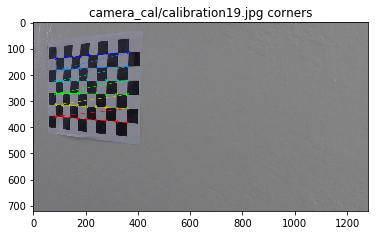

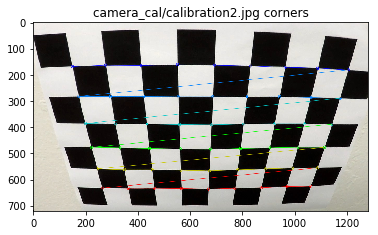

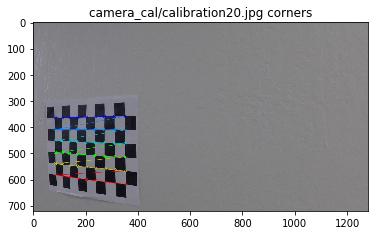

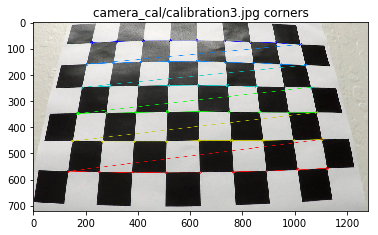

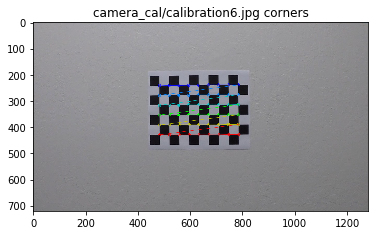

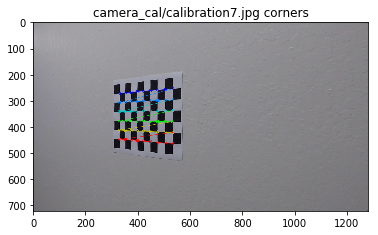

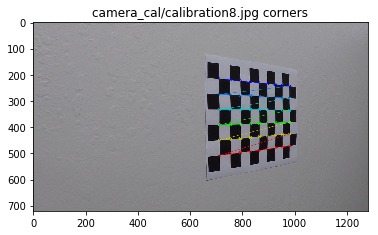

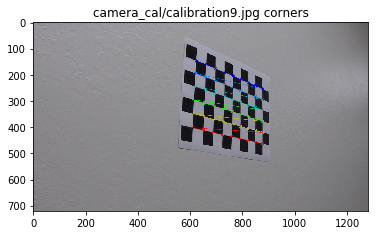

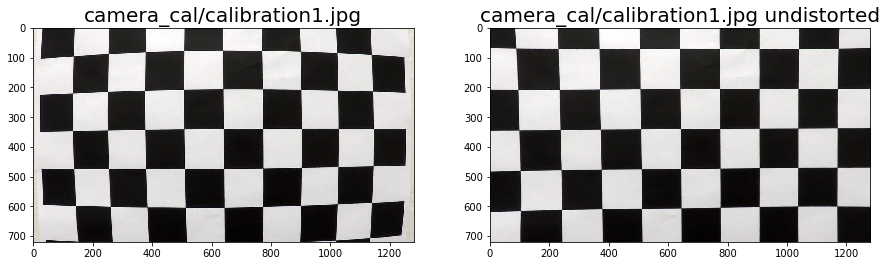

In [2]:
import glob
import os

# Make a list of calibration image files
imgfiles = glob.glob('camera_cal/calibration*.jpg')

# Get corresponding object/image points assuming 9x6 checkerboard
objpoints, imgpoints, imgsize = getpoints(imgfiles, nx=9, ny=6, drawcorners=True)

# Compute calibration matrix and distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imgsize, None, None)

# Load a calibration image and undistort it
examplefile = imgfiles[0]
img = mpimg.imread(examplefile)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Plot the before and after
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,30))
ax1.imshow(img)
ax1.set_title(examplefile, fontsize=20)
ax2.imshow(dst)
ax2.set_title(examplefile + ' undistorted', fontsize=20)
name, ext = os.path.splitext(os.path.basename(examplefile))
fig.savefig('examples/' + name + '_undistortion' + ext, bbox_inches='tight')

assert ret, "Problem Calibrating Camera!"

## Pipeline step analysis/visualization examples (test images)

<a id='apply_distortion'></a>

### 2. Apply a distortion correction to raw images.

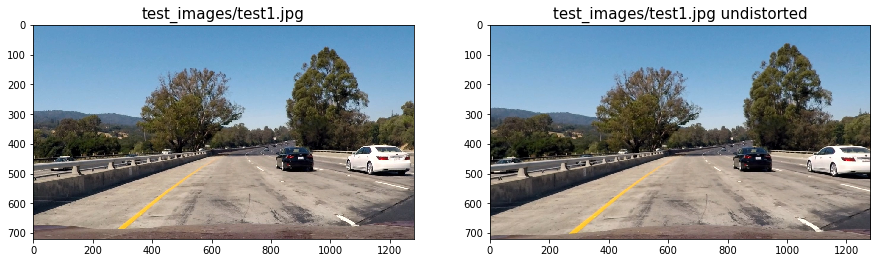

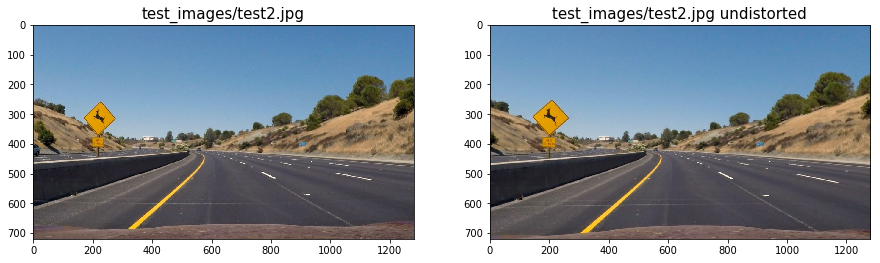

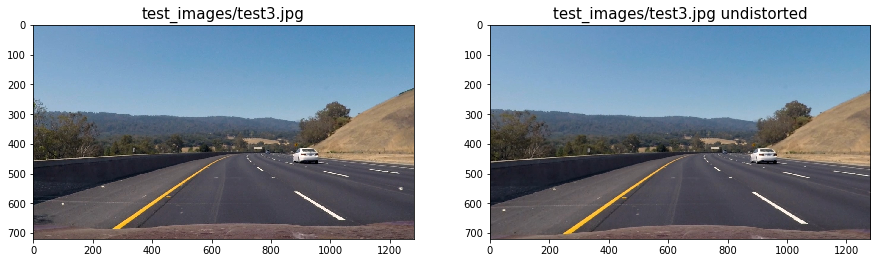

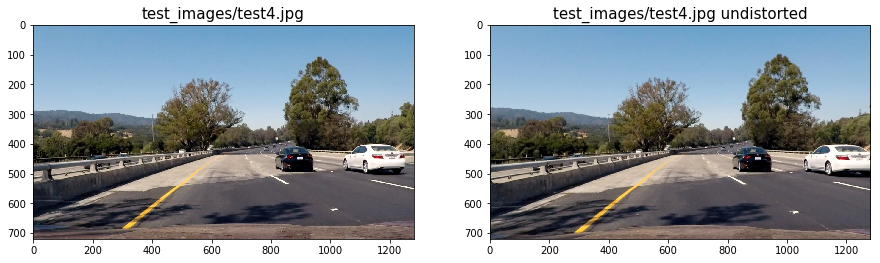

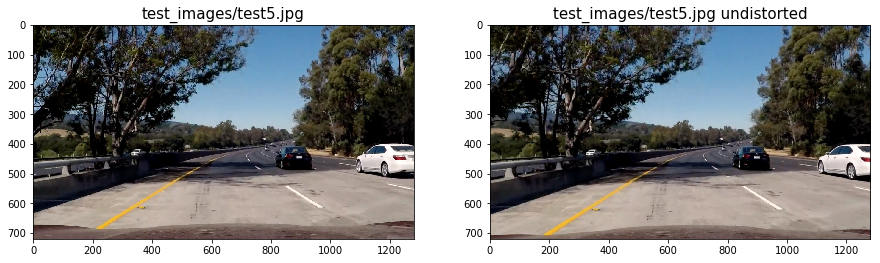

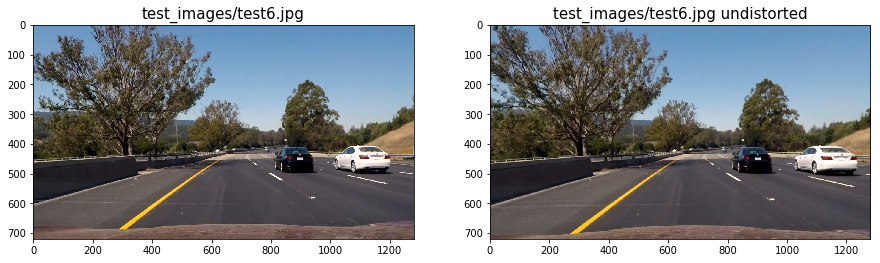

In [3]:
examplefiles = glob.glob('test_images/test*.jpg')

for examplefile in examplefiles:

    # Load a test image and undistort it
    img = mpimg.imread(examplefile)
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    # Plot the before and after
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,30))
    ax1.imshow(img)
    ax1.set_title(examplefile, fontsize=15)
    ax2.imshow(dst)
    ax2.set_title(examplefile + ' undistorted', fontsize=15)
    name, ext = os.path.splitext(os.path.basename(examplefile))
    fig.savefig('examples/' + name + '_undistortion' + ext, bbox_inches='tight')

<a id='create_binary'></a>

### 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [4]:
def get_color_channel(img, cvtmode, channel_idx=0):
    '''Apply desired color conversion and return the desired channel'''
    
    # Convert color space
    img_cvt = cv2.cvtColor(img, cvtmode)

    # Select desired color channel
    img_cvt = np.atleast_3d(img_cvt) # in case it's grayscale
    channel_img = img_cvt[:, :, channel_idx]
    
    return channel_img


def deriv_mag_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255),
                     cvtmode=cv2.COLOR_RGB2GRAY, channel_idx=0):
    '''Apply Sobel x or y, take the absolute value and apply thresholds
       to produce boolean pixel mask'''
    
    # Convert colorspace and select desired channel
    ch_img = get_color_channel(img, cvtmode, channel_idx=channel_idx)
    
    # Take the partial derivative wrt x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(ch_img, cv2.CV_64F, 1, 0)
    elif orient=='y':
        sobel = cv2.Sobel(ch_img, cv2.CV_64F, 0, 1)
    else:
        raise ValueError("orient can be 'x' or 'y'")
    
    # Take the absolute value of that partial derivative
    abs_sobel = np.abs(sobel)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    # Create a boolean mask of 'True' pixels using thresh interval
    boolean_mask = (scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])
    
    return boolean_mask


def grad_mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255),
                    cvtmode=cv2.COLOR_RGB2GRAY, channel_idx=0):
    '''Apply Sobel x and y, compute the magnitude of the gradient
       and apply thresholds to produce boolean pixel mask'''

    # Convert colorspace and select desired channel
    ch_img = get_color_channel(img, cvtmode, channel_idx=channel_idx)
    
    # Compute the x and y components of the gradient
    sobelx = cv2.Sobel(ch_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(ch_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude 
    mag = np.sqrt(sobelx**2 + sobely**2)
    
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_mag = np.uint8(255 * mag / mag.max())
    
    # Create a boolean mask of 'True' pixels using thresh interval
    boolean_mask = (scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])

    return boolean_mask


def grad_dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2),
                    cvtmode=cv2.COLOR_RGB2GRAY, channel_idx=0):
    '''Apply Sobel x and y, compute the gradient direction and apply
       thresholds to produce boolean pixel mask'''

    # Convert colorspace and select desired channel
    ch_img = get_color_channel(img, cvtmode, channel_idx=channel_idx)
    
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(ch_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(ch_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    angle = np.arctan2(abs_sobely, abs_sobelx)
    
    # Create a boolean mask of 'True' pixels using thresh interval
    boolean_mask = (angle > thresh[0]) & (angle < thresh[1])

    return boolean_mask


def color_thresh(img, thresh=(0, 255), cvtmode=cv2.COLOR_RGB2HLS,
                 channel_idx=2):
    '''Optionally convert to another colorspace, then threshold the desired channel
       to produce a boolean pixel mask.
       By default it takes an RGB image, converts it to HLS and thresholds the
       S channel to produce a boolean pixel mask'''
    
    # Convert colorspace and select desired channel
    ch_img = get_color_channel(img, cvtmode, channel_idx=channel_idx)
    
    # Create a boolean mask of 'True' pixels using thresh interval
    boolean_mask = (ch_img > thresh[0]) & (ch_img <= thresh[1])

    return boolean_mask


def get_pixel_mask(img):
    '''Use colorspace conversions, color thresholds and gradients to produce images mapped
       to max/min pixel values representing a boolean mask of selected pixels. Returns 
       gradient/color combined as well as stacked for debug/analysis.'''
    
    # Create boolean masks using each technique
    x_mask = deriv_mag_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100),
                              cvtmode=cv2.COLOR_RGB2HLS, channel_idx=1)
    y_mask = deriv_mag_thresh(img, orient='y', sobel_kernel=3, thresh=(20, 100),
                              cvtmode=cv2.COLOR_RGB2HLS, channel_idx=1)
    mag_mask = grad_mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 100),
                               cvtmode=cv2.COLOR_RGB2HLS, channel_idx=1)
    dir_mask = grad_dir_thresh(img, sobel_kernel=15, thresh=(0.7, 1.3),
                               cvtmode=cv2.COLOR_RGB2HLS, channel_idx=1)
    color_mask = color_thresh(img, thresh=(170, 255), cvtmode=cv2.COLOR_RGB2HLS, channel_idx=2)

    # Combine the partial derivative and gradient magnitude and direction masks
    grad_mask = (x_mask) | (mag_mask & dir_mask)

    # Combine gradient and color masks
    grad_color_mask = grad_mask | color_mask
    
    # Create black and white image of the fully combined mask
    grad_color_img = np.uint8(grad_color_mask*255)
    
    # Create stacked image of color and grad masks for visualizing the contribution of each
    grad_color_img_stacked = np.dstack((np.zeros_like(grad_mask, np.uint8),
                                np.uint8(grad_mask*255),
                                np.uint8(color_mask*255)))
    
    return grad_color_img, grad_color_img_stacked
    
    

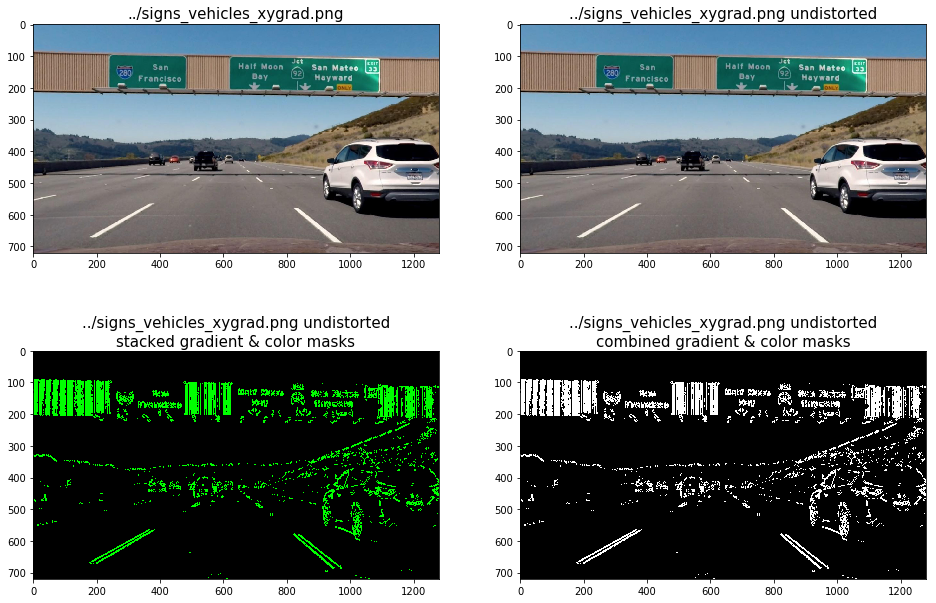

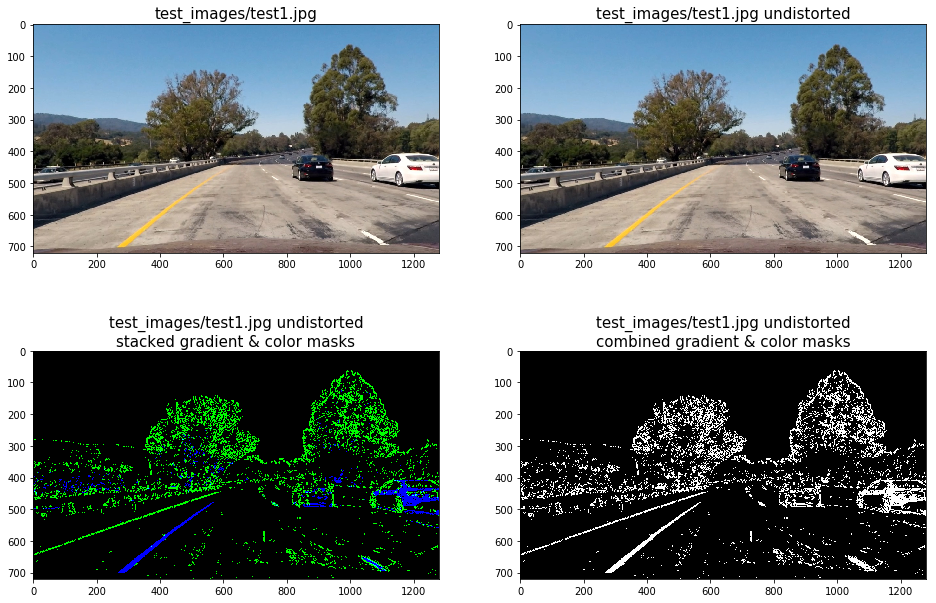

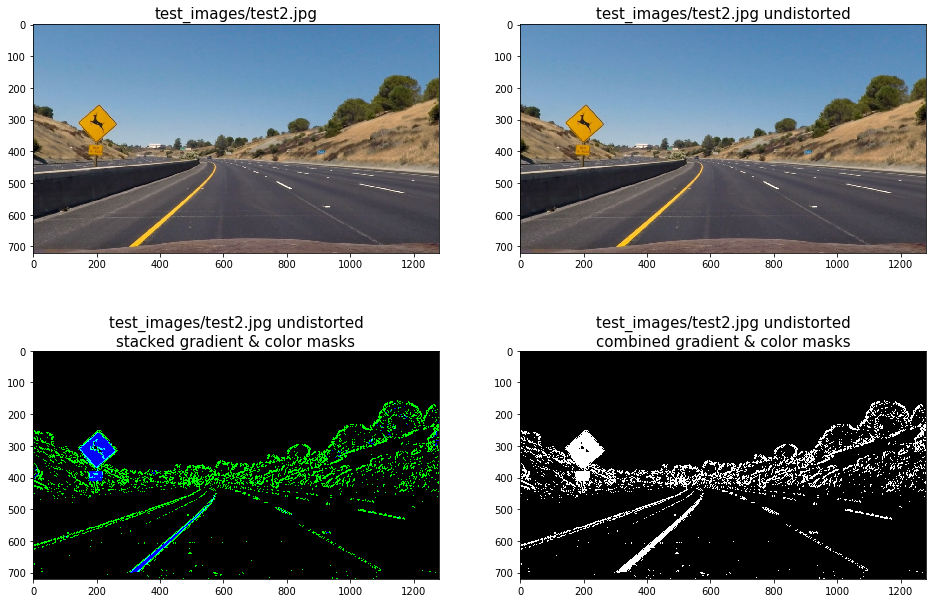

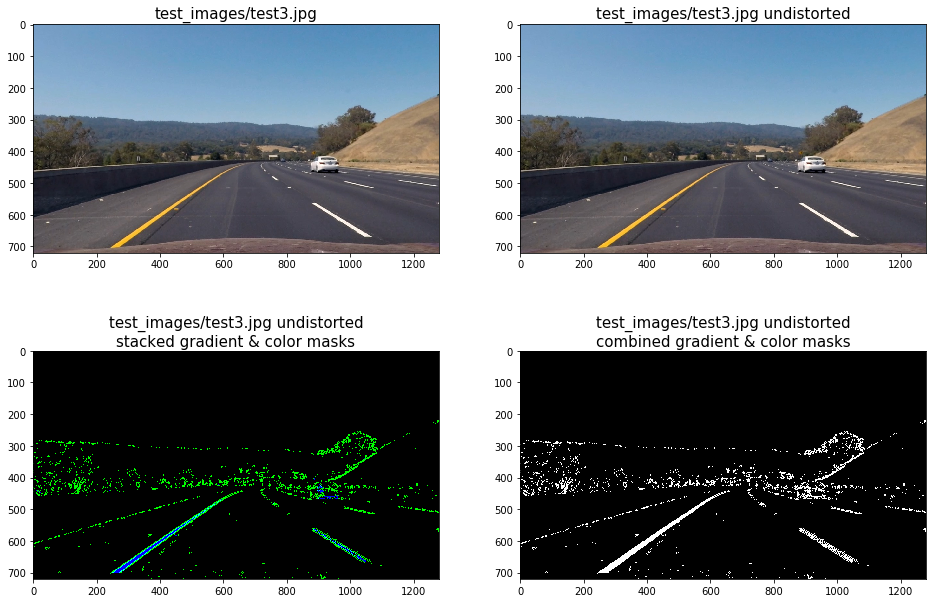

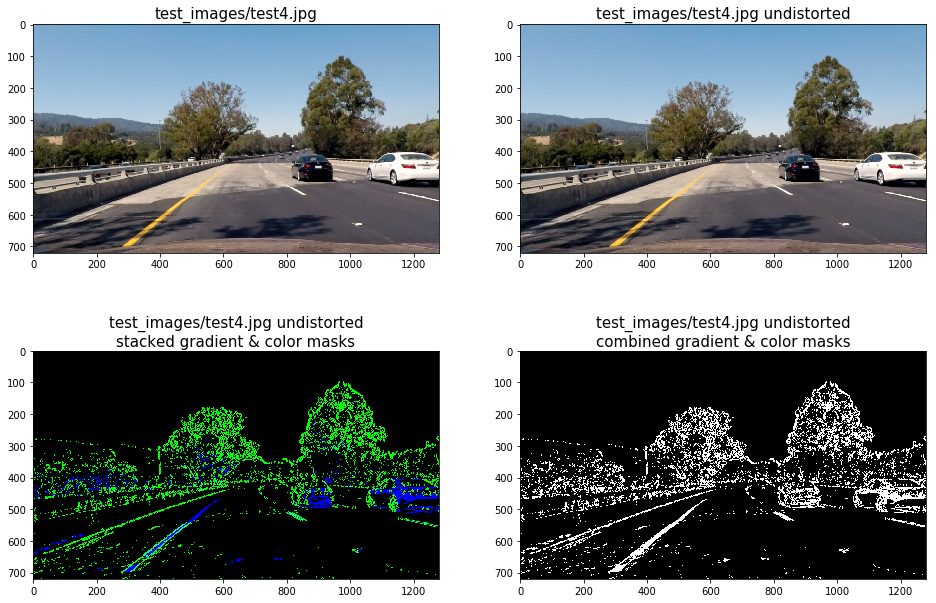

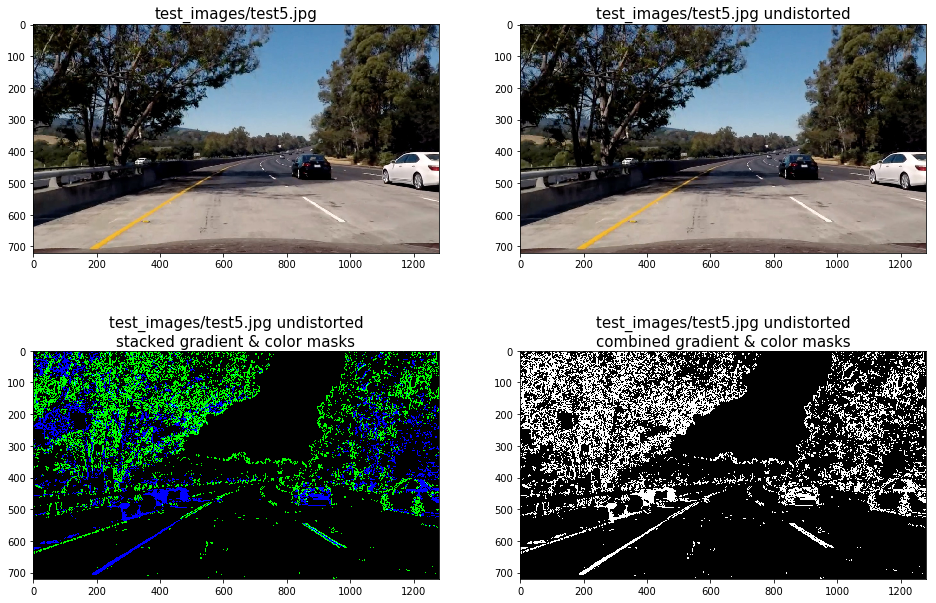

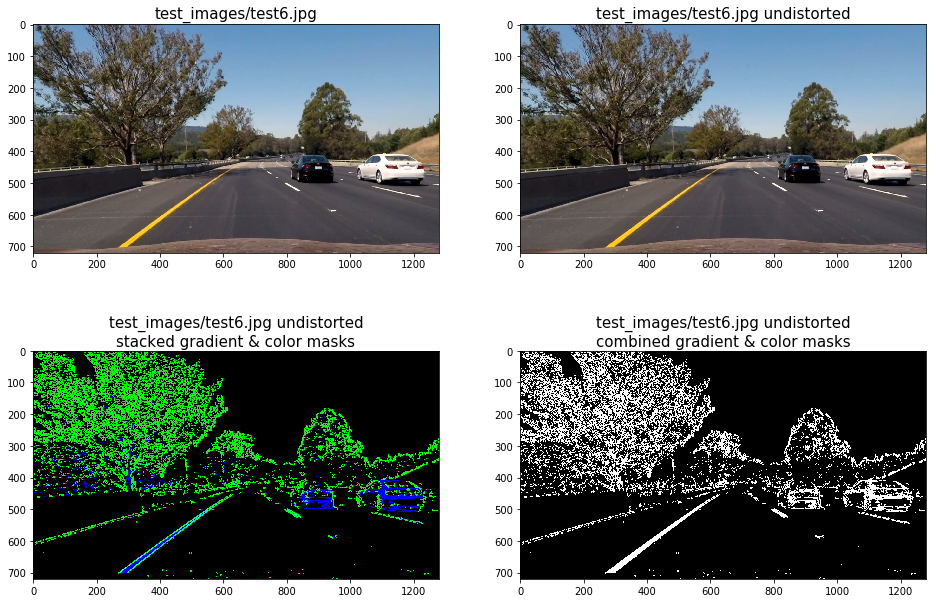

In [5]:
examplefiles = ['../signs_vehicles_xygrad.png'] + glob.glob('test_images/test*.jpg')

for examplefile in examplefiles:
    
    # Load a test image
    img = mpimg.imread(examplefile)
    
    # Correct for camera distortion
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    # Get binary mask images
    combined, stacked = get_pixel_mask(dst)

    # Plot the before and after
    fig, ax = plt.subplots(2, 2, figsize=(16,11))
    ax[0,0].imshow(dst)
    ax[0,0].set_title(examplefile, fontsize=15)
    ax[0,1].imshow(dst)
    ax[0,1].set_title(examplefile + ' undistorted', fontsize=15)
    ax[1,0].imshow(stacked)
    ax[1,0].set_title(examplefile + ' undistorted\nstacked gradient & color masks', fontsize=15)
    ax[1,1].imshow(combined, cmap='gray')
    ax[1,1].set_title(examplefile + ' undistorted\ncombined gradient & color masks', fontsize=15)
    
    name, ext = os.path.splitext(os.path.basename(examplefile))
    fig.savefig('examples/' + name + '_binary' + ext, bbox_inches='tight')

<a id='perspective'></a>

### 4. Apply a perspective transform to rectify binary image ("birds-eye view").

In [6]:
import tabulate

# src points rectangle vertices
srcpoints = np.float32(
    [[(imgsize[0] / 2) - 60, imgsize[1] / 2 + 100],
    [((imgsize[0] / 6) - 10), imgsize[1]],
    [(imgsize[0] * 5 / 6) + 40, imgsize[1]],
    [(imgsize[0] / 2 + 64), imgsize[1] / 2 + 100]])

# dst points rectangle vertices
dstpoints = np.float32(
    [[(imgsize[0] / 4), 0],
    [(imgsize[0] / 4), imgsize[1]],
    [(imgsize[0] * 3 / 4), imgsize[1]],
    [(imgsize[0] * 3 / 4), 0]])

print(tabulate.tabulate({'srcpoints':srcpoints, 'dstpoints':dstpoints},
                        headers='keys', tablefmt='pipe'))

# Compute perspective transform matrix, M
M = cv2.getPerspectiveTransform(srcpoints, dstpoints)

| srcpoints                       | dstpoints     |
|:--------------------------------|:--------------|
| [ 580.  460.]                   | [ 320.    0.] |
| [ 203.33332825  720.        ]   | [ 320.  720.] |
| [ 1106.66662598   720.        ] | [ 960.  720.] |
| [ 704.  460.]                   | [ 960.    0.] |


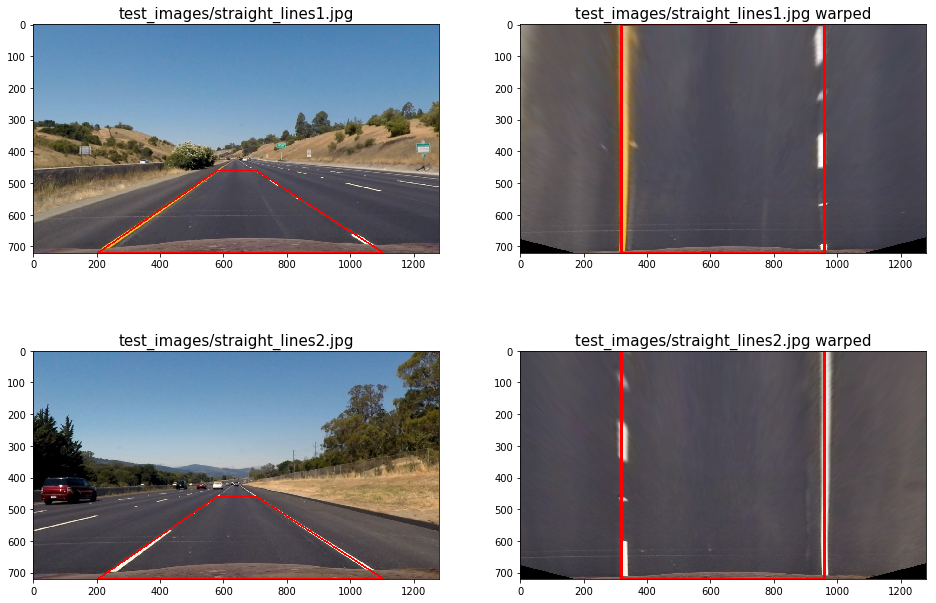

In [7]:
straight_examplefiles = glob.glob('test_images/straight_lines*.jpg')

# Create subplot axes with appropriate shape and size
fig, ax = plt.subplots(2, 2, figsize=(16, 11))

for idx, examplefile in enumerate(straight_examplefiles):
    
    # load image
    img = mpimg.imread(examplefile)
    
    # correct for camera distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Warp image perspective to a top-down view
    warped = cv2.warpPerspective(undist, M, imgsize, flags=cv2.INTER_LINEAR)
    
    # Draw source and destination point "rectangles"
    cv2.polylines(undist,[srcpoints.reshape((-1,1,2)).astype(np.int32)],True,(255,0,0), thickness=4)
    cv2.polylines(warped,[dstpoints.reshape((-1,1,2)).astype(np.int32)],True,(255,0,0), thickness=8)
    
    # Plot them
    ax[idx,0].imshow(undist)
    ax[idx,0].set_title(examplefile, fontsize=15)
    ax[idx,1].imshow(warped)
    ax[idx,1].set_title(examplefile + ' warped', fontsize=15)
    
fig.savefig('examples/straight_lines_warped.jpg', bbox_inches='tight')

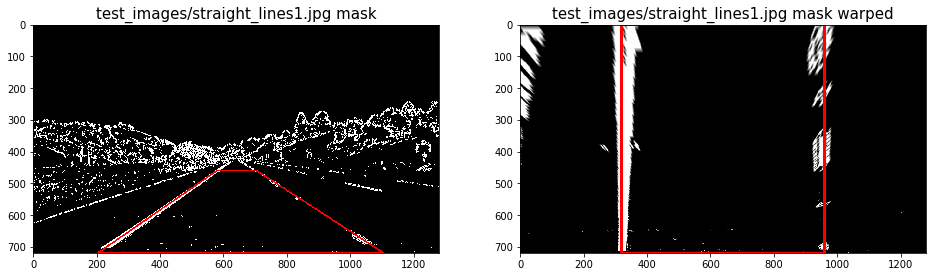

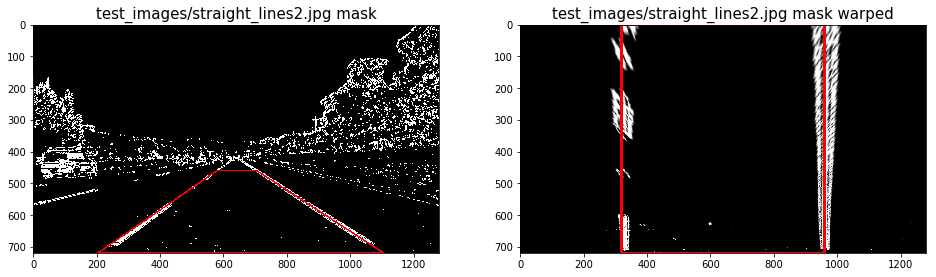

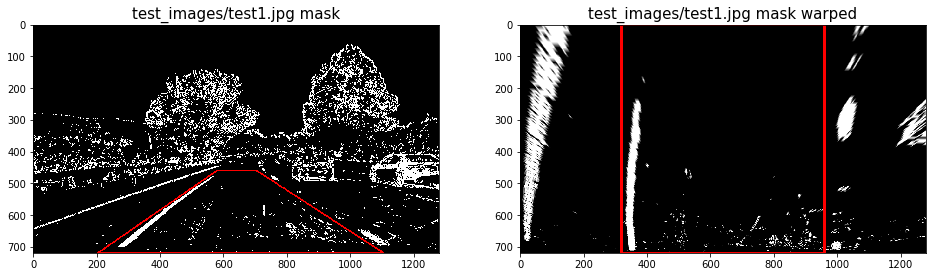

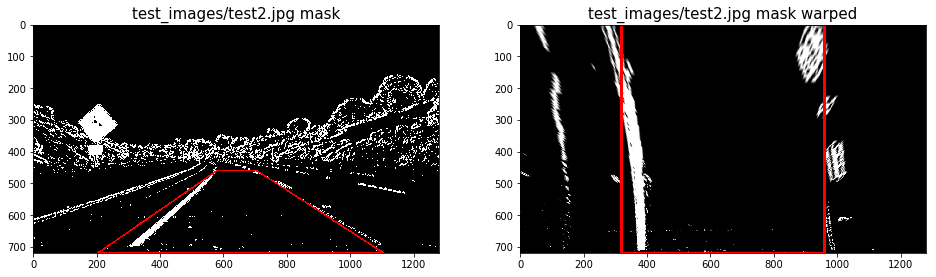

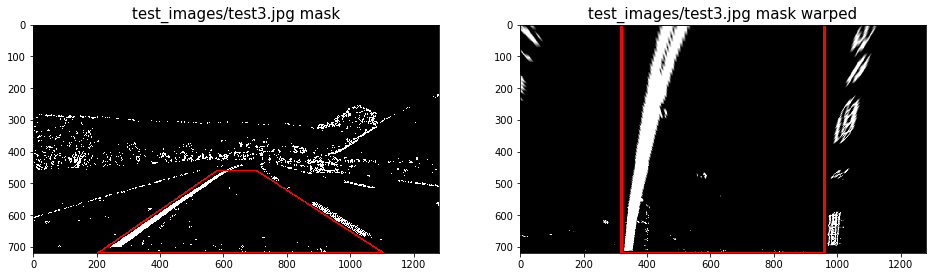

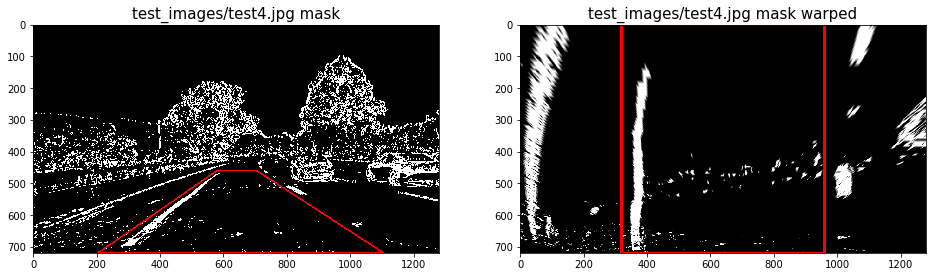

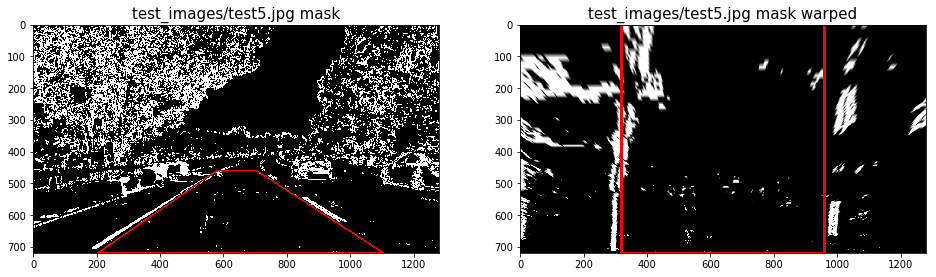

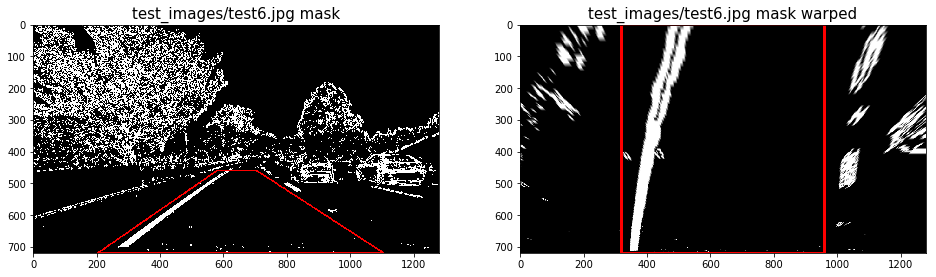

In [8]:
examplefiles = glob.glob('test_images/*.jpg')

for examplefile in examplefiles:
    
    # Load a test image
    img = mpimg.imread(examplefile)
    
    # Correct for camera distortion
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    # Get binary mask image
    combined,_ = get_pixel_mask(dst)
    
    # Warp binary mask images
    combined_warped = cv2.warpPerspective(combined, M, imgsize, flags=cv2.INTER_LINEAR)
    
    # Draw source and destination point "rectangles"
    combined = np.dstack([combined]*3)
    combined_warped = np.dstack([combined_warped]*3)
    cv2.polylines(combined,[srcpoints.reshape((-1,1,2)).astype(np.int32)],True,(255,0,0), thickness=4)
    cv2.polylines(combined_warped,[dstpoints.reshape((-1,1,2)).astype(np.int32)],True,(255,0,0), thickness=8)
    
    # Plot them
    fig, ax = plt.subplots(1, 2, figsize=(16, 5.5))
    ax[0].imshow(combined)
    ax[0].set_title(examplefile + ' mask', fontsize=15)
    ax[1].imshow(combined_warped)
    ax[1].set_title(examplefile + ' mask warped', fontsize=15)
    
    name, ext = os.path.splitext(os.path.basename(examplefile))
    fig.savefig('examples/' + name + '_binary_warped' + ext, bbox_inches='tight')

<a id='fit_lane'></a>

### 5. Detect lane pixels and fit to find the lane boundary.

In [9]:
def get_windowed_pts(image, window_center, window_width, window_height, out_img=None, level=0):
    '''Get pixel (y,x) points within the window'''
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = np.transpose(image.nonzero())
    nonzeroy = nonzero[:,0]
    nonzerox = nonzero[:,1]
    
    # Identify window boundaries in x and y (and right and left)
    win_y_low = np.int(image.shape[0] - (level + 1)*window_height)
    win_y_high = np.int(image.shape[0] - level*window_height)
    win_x_low = np.int(window_center - window_width//2)
    win_x_high = np.int(window_center + window_width//2)
    
    if out_img is not None:
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_x_low,win_y_low),(win_x_high,win_y_high),(0,255,0), 3) 
    
    # Identify the nonzero pixels in x and y within the window
    windowed_pts = nonzero[(nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_x_low) & (nonzerox < win_x_high), :]
    
    return windowed_pts


def compute_conv_signal(image, window_width, window_height, level):
    
    # convolve the window into the vertical slice of the image
    image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):
                               int(image.shape[0]-level*window_height),:], axis=0)
    conv_signal = np.convolve(np.ones(window_width), image_layer)
    
    return conv_signal


def compute_window_center(image, prev_center, window_width, margin, conv_signal):

    # Find the best centroid by using past center as a reference
    # Use window_width/2 as offset because convolution signal reference is at right side of
    # window, not center of window
    offset = window_width/2
    min_index = int(max(prev_center+offset-margin,0))
    max_index = int(min(prev_center+offset+margin,warped.shape[1]))
    center = np.argmax(conv_signal[min_index:max_index])+min_index-offset
    
    return center


def fit_lanes_conv(image, window_width, window_height, margin, out_img=None):
    '''Fit polynomials to lane lines using convolutional window positioning method'''

    left_lane_pts = []
    right_lane_pts = []

    ######### Compute inital values for level 0
    # First find the two starting positions for the left and right lane windows by using np.sum
    # to get the vertical image slice and then np.convolve the vertical image slice with the
    # window template.
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(np.ones(window_width),l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(np.ones(window_width),r_sum))-window_width/2+int(warped.shape[1]/2)

    # Identify the nonzero pixels in x and y within the window
    good_left_pts = get_windowed_pts(image, l_center, window_width, window_height, out_img, level=0)
    good_right_pts = get_windowed_pts(image, r_center, window_width, window_height, out_img, level=0)

    # Append first layer pixel inds
    left_lane_pts.append(good_left_pts)
    right_lane_pts.append(good_right_pts)

    
    ######### Go through each subsequent level using convolutional window positioning method
    for level in range(1,(int)(image.shape[0]/window_height)):
        
        # convolve vertically summed slice with rectangular window
        conv_signal = compute_conv_signal(image, window_width, window_height, level)
        
        # find window center locations yielding the most pixels within sliding margin
        l_center = compute_window_center(image, l_center, window_width, margin, conv_signal)
        r_center = compute_window_center(image, r_center, window_width, margin, conv_signal)
        
        # Identify the nonzero pixels within the windows
        good_left_pts = get_windowed_pts(image, l_center, window_width, window_height, out_img, level=level)
        good_right_pts = get_windowed_pts(image, r_center, window_width, window_height, out_img, level=level)

        # Append pixel pts
        left_lane_pts.append(good_left_pts)
        right_lane_pts.append(good_right_pts)
    
    
    # Concatenate the arrays of indices
    left_lane_pts = np.concatenate(left_lane_pts)
    right_lane_pts = np.concatenate(right_lane_pts)

    if out_img is not None:
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(left_lane_pts[:, 0], left_lane_pts[:, 1], 2)
        right_fit = np.polyfit(right_lane_pts[:, 0], right_lane_pts[:, 1], 2)

        # Generate x and y values for plotting the polynomials
        ploty = np.arange(0,image.shape[0],10)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Draw the polynomials
        pts = np.stack((np.int32(np.round(left_fitx)), np.int32(ploty)), axis=1).reshape((-1,1,2))
        cv2.polylines(out_img,[pts],False,(255,255,0), 10)
        pts = np.stack((np.int32(right_fitx), np.int32(ploty)), axis=1).reshape((-1,1,2))
        cv2.polylines(out_img,[pts],False,(255,255,0), 10)
        
    return left_lane_pts, right_lane_pts


def fit_lanes_pixelmean(image, nwindows, margin, minpix, out_img=None):
    '''Fit polynomials to lane lines using pixel mean window positioning method'''

    left_lane_pts = []
    right_lane_pts = []
    window_height = image.shape[0]//nwindows
    
    ######### Compute inital values for left and right window positions
    # Take a histogram of the bottom half of the image
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = histogram.shape[0]//2
    leftx_current = np.argmax(histogram[:midpoint])
    rightx_current = np.argmax(histogram[midpoint:]) + midpoint

    ######### Go through each level using pixel mean window positioning method
    for level in range(nwindows):

        # Identify the nonzero pixels in x and y within the window
        good_left_pts = get_windowed_pts(image, leftx_current, margin*2, window_height, out_img, level=level)
        good_right_pts = get_windowed_pts(image, rightx_current, margin*2, window_height, out_img, level=level)
        # Append these indices to the lists
        left_lane_pts.append(good_left_pts)
        right_lane_pts.append(good_right_pts)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_pts) > minpix:
            leftx_current = np.int(good_left_pts[:,1].mean())
        if len(good_right_pts) > minpix:        
            rightx_current = np.int(good_right_pts[:,1].mean())


    # Concatenate the arrays of indices
    left_lane_pts = np.concatenate(left_lane_pts)
    right_lane_pts = np.concatenate(right_lane_pts)

    if out_img is not None:
    
        # Fit a second order polynomial to each
        left_fit = np.polyfit(left_lane_pts[:, 0], left_lane_pts[:, 1], 2)
        right_fit = np.polyfit(right_lane_pts[:, 0], right_lane_pts[:, 1], 2)

        # Generate x and y values for plotting the polynomials
        ploty = np.arange(0,image.shape[0],10)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Draw the polynomials
        pts = np.stack((np.int32(np.round(left_fitx)), np.int32(ploty)), axis=1).reshape((-1,1,2))
        cv2.polylines(out_img,[pts],False,(255,255,0), 10)
        pts = np.stack((np.int32(right_fitx), np.int32(ploty)), axis=1).reshape((-1,1,2))
        cv2.polylines(out_img,[pts],False,(255,255,0), 10)

    return left_lane_pts, right_lane_pts


def get_polymargin_pts(image, fit_coefs, margin, out_img=None):
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = np.transpose(image.nonzero())
    nonzeroy = nonzero[:,0]
    nonzerox = nonzero[:,1]
    
    # Identify the nonzero pixels in x and y within the window
    windowed_pts = nonzero[(nonzerox > (fit_coefs[0]*(nonzeroy**2)
                                        + fit_coefs[1]*nonzeroy
                                        + fit_coefs[2]
                                        - margin)) &
                           (nonzerox < (fit_coefs[0]*(nonzeroy**2)
                                        + fit_coefs[1]*nonzeroy
                                        + fit_coefs[2]
                                        + margin)), :]
    
    if out_img is not None:
        
        # Generate x and y values for plotting the search boundaries
        ploty = np.arange(0,image.shape[0],10)
        fitx = fit_coefs[0]*ploty**2 + fit_coefs[1]*ploty + fit_coefs[2]

        # Draw the search boundaries
        pts = np.stack((np.int32(np.round(fitx - margin)), np.int32(ploty)), axis=1).reshape((-1,1,2))
        cv2.polylines(out_img,[pts],False,(0,255,0), 3)
        pts = np.stack((np.int32(fitx + margin), np.int32(ploty)), axis=1).reshape((-1,1,2))
        cv2.polylines(out_img,[pts],False,(0,255,0), 3)
    
    return windowed_pts
    

def fit_lanes_poly(image, prev_left_fit, prev_right_fit, margin, out_img=None):
    '''Fit polynomials to lane lines using previous polynomial with margin pixel selection method'''
    
    left_lane_pts = get_polymargin_pts(image, fit_coefs=prev_left_fit, margin=margin, out_img=out_img)
    right_lane_pts = get_polymargin_pts(image, fit_coefs=prev_right_fit, margin=margin, out_img=out_img)
    
    if out_img is not None:
    
        # Fit a second order polynomial to each
        left_fit = np.polyfit(left_lane_pts[:, 0], left_lane_pts[:, 1], 2)
        right_fit = np.polyfit(right_lane_pts[:, 0], right_lane_pts[:, 1], 2)

        # Generate x and y values for plotting the polynomials
        ploty = np.arange(0,image.shape[0],10)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Draw the polynomials
        pts = np.stack((np.int32(np.round(left_fitx)), np.int32(ploty)), axis=1).reshape((-1,1,2))
        cv2.polylines(out_img,[pts],False,(255,255,0), 10)
        pts = np.stack((np.int32(right_fitx), np.int32(ploty)), axis=1).reshape((-1,1,2))
        cv2.polylines(out_img,[pts],False,(255,255,0), 10)

    return left_lane_pts, right_lane_pts

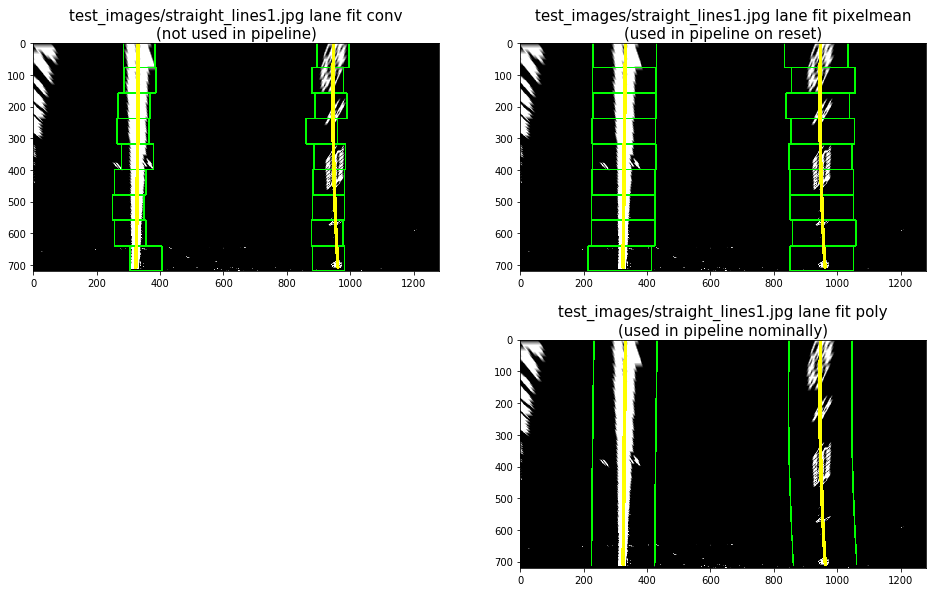

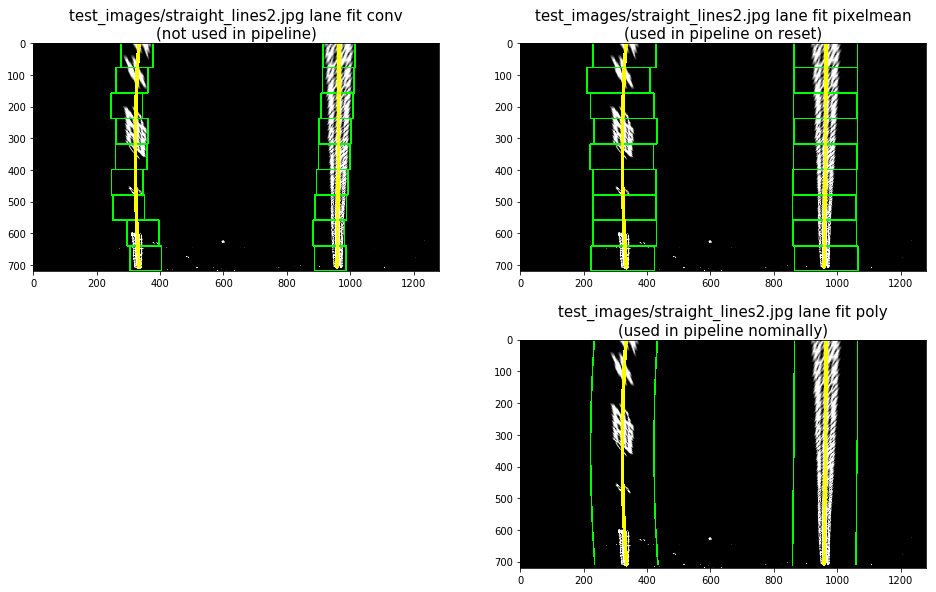

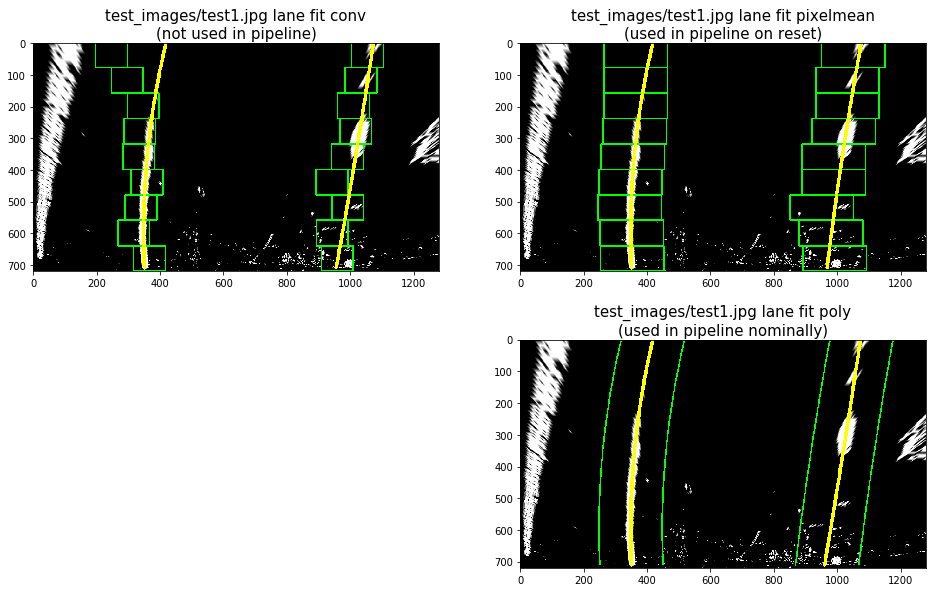

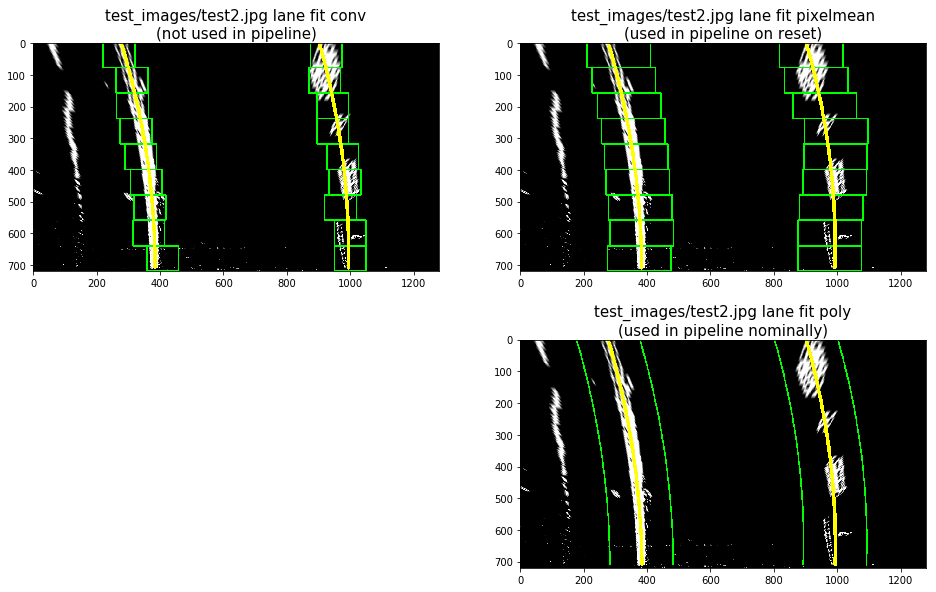

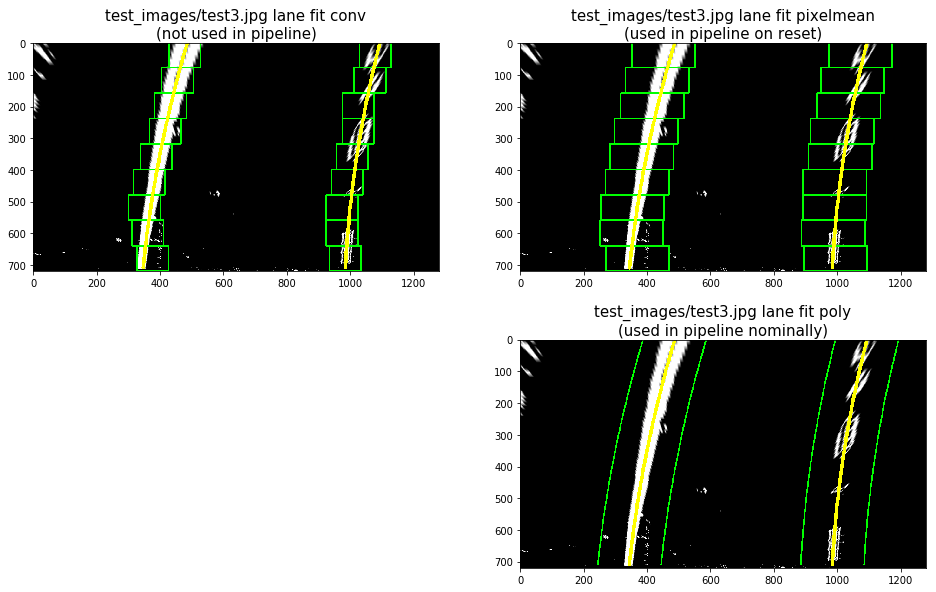

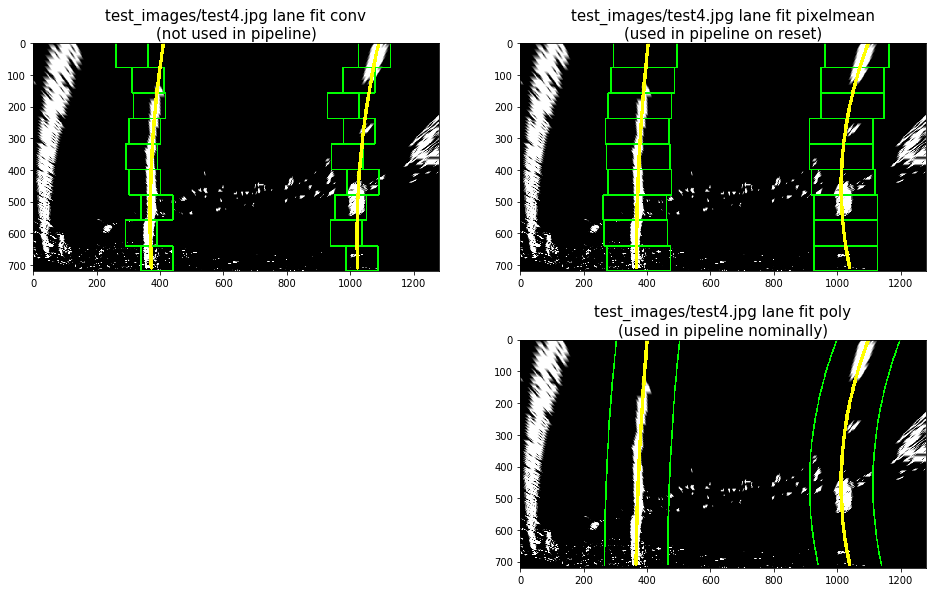

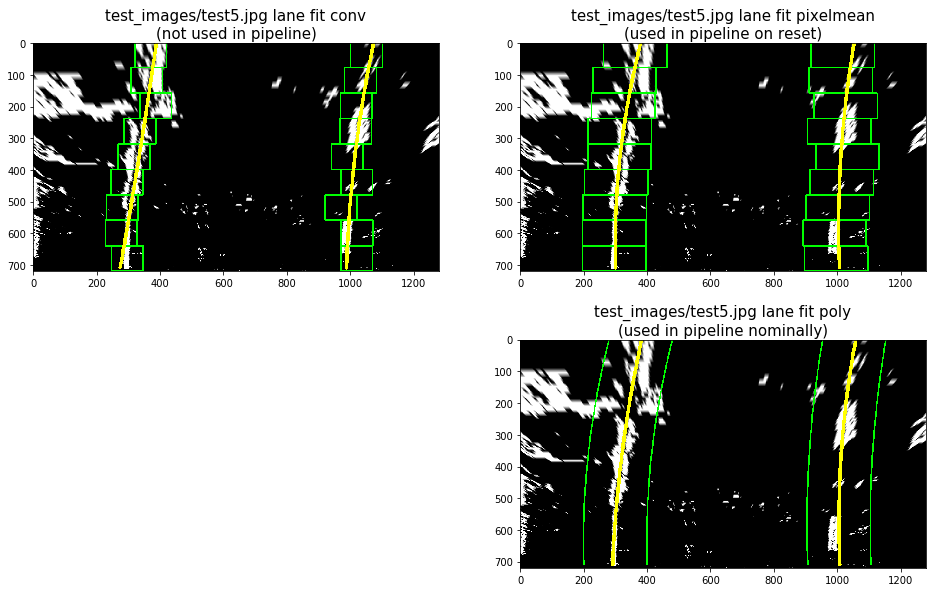

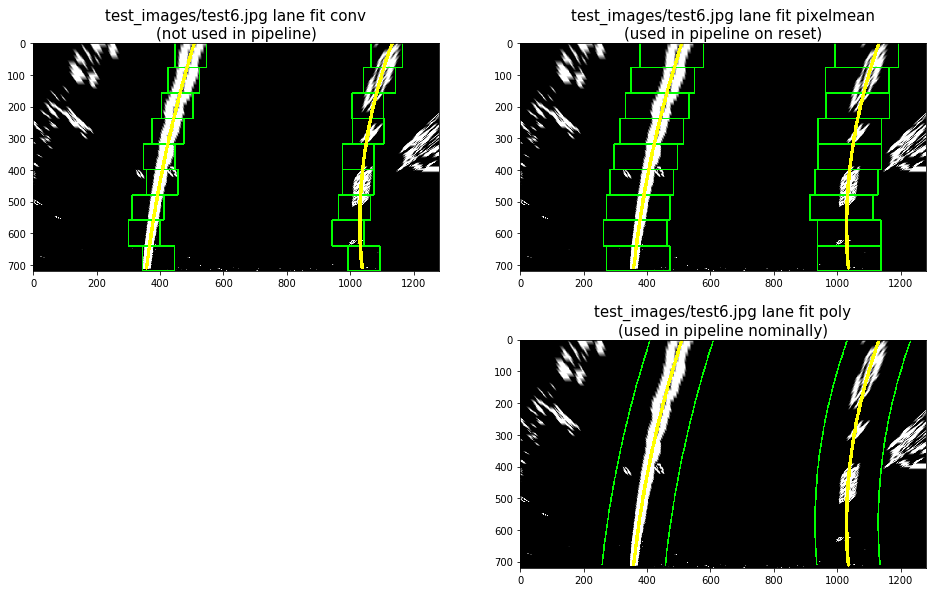

In [10]:
plt.close('all')

examplefiles = glob.glob('test_images/*.jpg')

for examplefile in examplefiles:#['test_images/test4.jpg']:#examplefiles:
    
    # Load a test image
    img = mpimg.imread(examplefile)

    # Correct for camera distortion
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    # Get binary mask image
    combined,_ = get_pixel_mask(dst)

    # Warp binary mask images
    warped = cv2.warpPerspective(combined, M, imgsize, flags=cv2.INTER_LINEAR)

    # Compute lane line polynomials using convolution window positioning
    window_width = 100 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 50 # How much to slide left and right for searching
    warped_conv = np.dstack([warped]*3) # color image to draw on for visualization of outcome
    left_pts_conv, right_pts_conv = fit_lanes_conv(warped, window_width, window_height, margin,
                                                   out_img=warped_conv)
    
    # Compute lane line polynomials using pixel mean window positioning
    nwindows = 9 # Choose the number of sliding windows
    margin = 100 # Set the width of the windows +/- margin
    minpix = 350 # Set minimum number of pixels found to recenter window
    warped_pmean = np.dstack([warped]*3) # color image to draw on for visualization of outcome
    left_pts_pmean, right_pts_pmean = fit_lanes_pixelmean(warped, nwindows, margin, minpix, out_img=warped_pmean)
    
    margin = 100 # Set search width surrounding previous lane line curve
    left_fit = np.polyfit(left_pts_pmean[:, 0], left_pts_pmean[:, 1], 2)
    right_fit = np.polyfit(right_pts_pmean[:, 0], right_pts_pmean[:, 1], 2)
    warped_poly = np.dstack([warped]*3) # color image to draw on for visualization of outcome
    left_pts_poly, right_pts_poly = fit_lanes_poly(warped, left_fit, right_fit, margin, out_img=warped_poly)

    # Plot all lane pixel fitting methods
    fig, ax = plt.subplots(2, 2, figsize=(16, 10))
    ax[0,0].imshow(warped_conv)
    ax[0,0].set_title(examplefile + ' lane fit conv\n(not used in pipeline)', fontsize=15)
    ax[0,1].imshow(warped_pmean)
    ax[0,1].set_title(examplefile + ' lane fit pixelmean\n(used in pipeline on reset)', fontsize=15)
    ax[1,1].imshow(warped_poly)
    ax[1,1].set_title(examplefile + ' lane fit poly\n(used in pipeline nominally)', fontsize=15)
    fig.delaxes(ax[1,0])
    
    name, ext = os.path.splitext(os.path.basename(examplefile))
    fig.savefig('examples/' + name + '_polyfit' + ext, bbox_inches='tight')

<a id="curvature"></a>

### 6. Determine the curvature of the lane and vehicle position with respect to center.

In [11]:
def compute_curvature(lane_pts, yeval, ym_per_pix=30/720, xm_per_pix = 3.7/700):
    '''
    Compute radius of curvature of a 2nd order polynomial at yeval.
       
    Parameters
    ----------
    lane_pts : nx2 numpy array
        array of (y,x) positions of this lane line's pixels
    yeval : float
        y value (in pixels) at which to compute radius of curvature.
    ym_per_pix : float
        meters per pixel in the y dimension
    xm_per_pix : float
        meters per pixel in the x dimension
        
    Returns
    -------
    curverad_m : float
        radius of curvature at yeval in meters
    '''
    # Convert pixels to meters
    lane_pts_m = lane_pts*np.array([[ym_per_pix, xm_per_pix]])
    yeval_m = yeval*ym_per_pix

    # Fit new polynomials to x,y in world space
    fit_m = np.polyfit(lane_pts_m[:,0], lane_pts_m[:,1], 2)
    
    # Calculate radius of curvature at yeval in meters
    curverad_m = ((1 + (2*fit_m[0]*yeval_m + fit_m[1])**2)**1.5) / np.abs(2*fit_m[0])
    
    return curverad_m

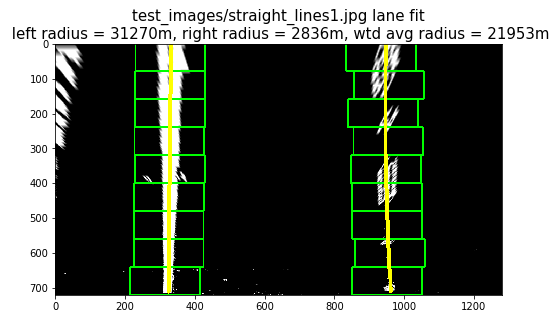

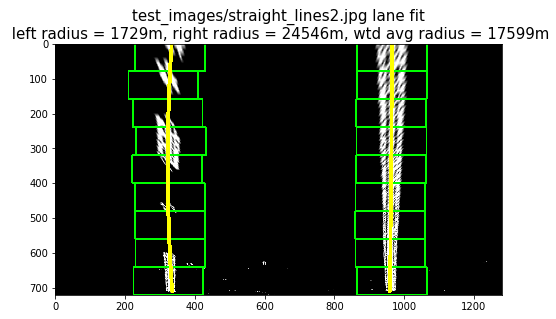

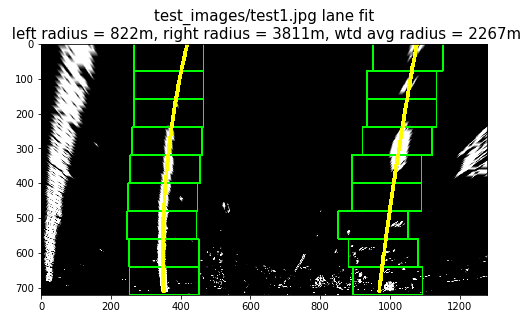

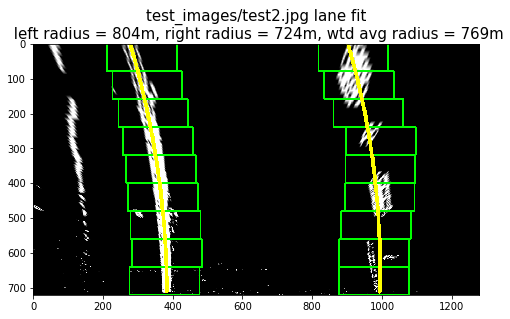

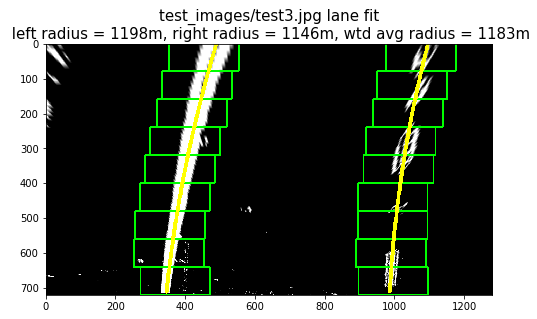

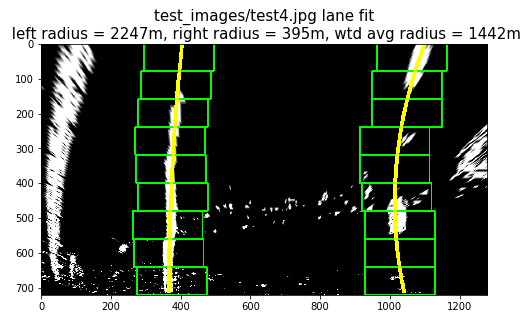

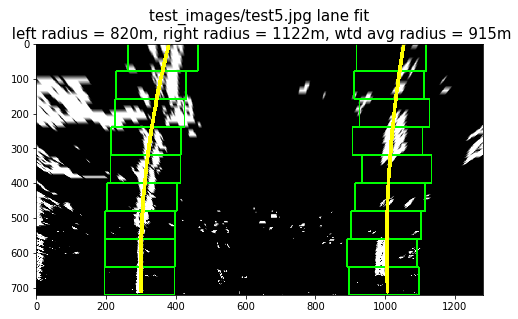

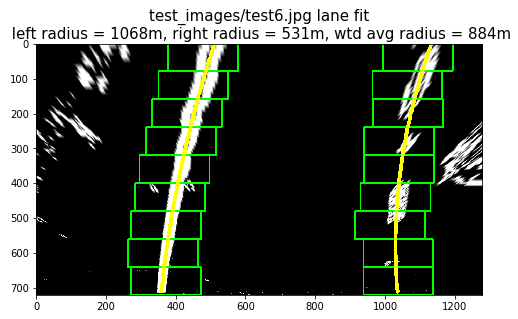

In [12]:
plt.close('all')

examplefiles = glob.glob('test_images/*.jpg')

for examplefile in examplefiles:#['test_images/test4.jpg']:#examplefiles:
    
    # Load a test image
    img = mpimg.imread(examplefile)

    # Correct for camera distortion
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    # Get binary mask image
    combined,_ = get_pixel_mask(dst)

    # Warp binary mask images
    warped = cv2.warpPerspective(combined, M, imgsize, flags=cv2.INTER_LINEAR)
    
    # Compute lane line polynomials using pixel mean window positioning
    nwindows = 9 # Choose the number of sliding windows
    margin = 100 # Set the width of the windows +/- margin
    minpix = 350 # Set minimum number of pixels found to recenter window
    warped_pmean = np.dstack([warped]*3) # color image to draw on for visualization of outcome
    left_pts, right_pts = fit_lanes_pixelmean(warped, nwindows, margin, minpix, out_img=warped_pmean)

    # Compute radii of curvature for each lane line
    yeval = warped.shape[0] - 1 # evaluate at bottom of image (car position)
    left_curverad = compute_curvature(left_pts, yeval, ym_per_pix=30/720, xm_per_pix =3.7/700)
    right_curverad = compute_curvature(right_pts, yeval, ym_per_pix=30/720, xm_per_pix =3.7/700)
    nleft = len(left_pts)
    nright = len(right_pts)
    avg_curverad = (left_curverad*nleft + right_curverad*nright) / (nleft + nright)
    
    # Plot lane line fit and radius of curvature
    plt.figure(figsize=(8,5))
    plt.imshow(warped_pmean)
    titlestr = (examplefile + ' lane fit\n left radius = {}m, right radius = {}m, wtd avg radius = {}m'
                .format(np.int(left_curverad), np.int(right_curverad), np.int(avg_curverad)))
    plt.title(titlestr, fontsize=15)
    
    name, ext = os.path.splitext(os.path.basename(examplefile))
    plt.gcf().savefig('examples/' + name + '_curverad' + ext, bbox_inches='tight')

<a id="warp_lane"></a>

### 7. Warp the detected lane boundaries back onto the original image.

<a id="final_output"></a>

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.